

***
# <font color=red> Application of Machine Learning Algorithms on Prediction of Parkinson's Disease </font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle Cloud Infrastructure </font></p>

***

## Overview:
This notebook provides a sample Parkinsons classification technique using OCI's data science tools using one's uttered speech.

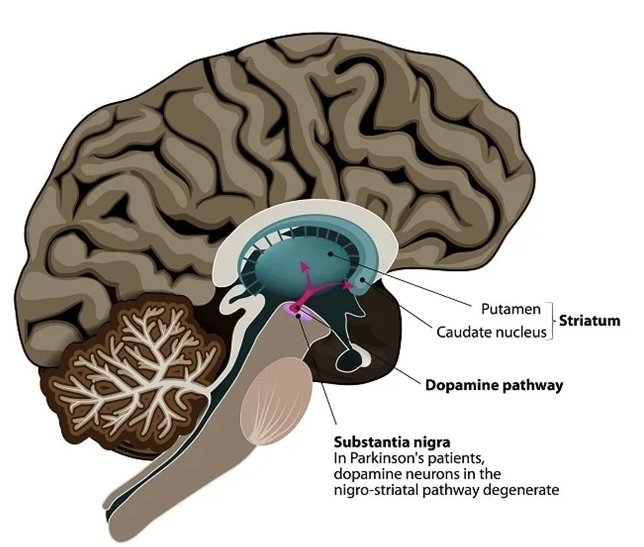    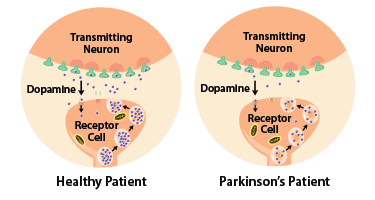

It demonstrates simple steps for training a model and deploying it to production.

---

## Contents:

* <a href='#intro'>Introduction</a>
    * <a href="#intro_dataset">Dataset</a>
    * <a href="#Data_Distribution">Data Distribution</a>
    * <a href="#Resample_data">Balanced Dataset</a>
    * <a href="#create_pipeline">Create Pileline Model and Fit</a>
* <a href='#create'>Create an Sklearn Model</a>
    * <a href="#compare_different_models">Compare Model performances</a>
* <a href='#serialize'>Sklearn Framework Serialization</a>
    * <a href='#serialize_sklearnmodel'>Create a SklearnModel</a>
    * <a href='#serialize_prepare'>Prepare</a>
    * <a href='#serialize_verify'>Verify</a>
    * <a href='#serialize_save'>Save</a>
    * <a href='#serialize_deploy'>Deploy</a>
    * <a href='#serialize_predict'>Predict</a>
* <a href='#req_resp'>Invoking the Endpoint</a>    
* <a href='#clean_up'>Clean Up</a>
* <a href='#ref'>References</a>    

---

**Important:**

`database_name = "<database_name>"` would become `database_name = "production"`.

---

<font color="gray">
Datasets are considered third-party content and are not considered materials under your agreement with Oracle.
      
You can access the Parkinsons dataset license [here](https://archive.ics.uci.edu/ml/datasets/parkinsons).
    
Citation: 'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection', Little MA, McSharry PE, Roberts SJ, Costello DAE, Moroz IM. BioMedical Engineering OnLine 2007, 6:23 (26 June 2007)
    
</font>

In [ ]:
# update packages. -q makes it silent
! pip install -U oci-cli==3.10.3 -q
! pip install -U oracle-ads==2.6.1 -q

In [1]:
import ads
import io
import logging
import matplotlib.pyplot as plt
import numpy as np
import oci
import os
import pandas as pd
import re
import requests
import seaborn as sns
import tempfile
import warnings

from ads.automl.driver import AutoML
from ads.model.framework.automl_model import AutoMLModel
from ads.model.framework.sklearn_model import SklearnModel
from ads.automl.provider import OracleAutoMLProvider
from ads.catalog.model import ModelCatalog
from ads.common.data import ADSData
from ads.common.model_metadata import UseCaseType
from ads.dataset.classification_dataset import BinaryClassificationDataset
from ads.dataset.factory import DatasetFactory
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_whatif_explainer import MLXWhatIfExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

from lightgbm import LGBMClassifier

from shutil import rmtree

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, get_scorer, plot_confusion_matrix, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from tensorflow.keras.optimizers import Adam

from xgboost import XGBClassifier

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)
warnings.filterwarnings('ignore')

In [2]:
ads.__version__

'2.6.2'

<a id='intro'></a>
# Introduction

Parkinson's Disease is a disorder of the central nervous system that affects movement, often including tremors. Nerve cell damage in the brain causes dopamine levels to drop, leading to the symptoms of Parkinson's. Parkinson's often starts with a tremor in one hand. Other symptoms are slow movement, stiffness, and loss of balance. Medications can help control the symptoms of Parkinson's.

There is no cure for Parkinson's Disease, which affects more than 6 million people worldwide, and no objective test or biomarker (discoverable by a blood test) to diagnose it. Instead, doctors perform neurological tests to assess patients' motor skills and rely largely on judgment, a process that can be time consuming and costly. Recent advances in speech disorder research has made remote and non-invasive tests to be done to detect unset of the disease. research at the MIT Media Lab, and the University of Oxford have provided an environment to achieve this goal. Voice is affected by Parkinson's as much as limb movement. The subtle changes in one's vocal cords and soft palate, including tremor, breathiness, and weakness can be analyzed for detecting the disease at early stages with a minimum cost to the patient and healthcare system.

Binary classification is a technique of classifying records/elements of a given dataset into two groups on the basis of classification rules for ex: Parkinsons Disease Attrition Prediction whether the individual is experincing disease or Not.

<a id="intro_dataset"></a>
## Dataset

This dataset contains 195 records of features extracted from group of healthy and unhealthy patients, which were then classified by experts physicians into two classes.

1. Normal
2. Abnormal
    
Data columns are:

- name - ASCII subject name and recording number
- MDVP:Fo(Hz) - Average vocal fundamental frequency
- MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
- MDVP:Flo(Hz) - Minimum vocal fundamental frequency
- MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, MDVP:PPQ, Jitter:DDP - Several measures of variation in fundamental frequency
- MDVP:Shimmer, MDVP:Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, MDVP:APQ, Shimmer:DDA - Several measures of variation in amplitude
- NHR, HNR - Two measures of ratio of noise to tonal components in the voice
- status - Health status of the subject (one) - Parkinson's, (zero) - healthy
- RPDE, D2 - Two nonlinear dynamical complexity measures
- DFA - Signal fractal scaling exponent
- spread1, spread2, PPE

In the following cell, the data will be downloaded and read into a pandas Dataframe.

In [3]:
def load_dataset():
    data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
    df = pd.read_csv(data_url, encoding='ASCII')
    return df

df = load_dataset()
df.shape

(195, 24)

In [4]:
df.head(5)

name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   

   Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0      0.06545  0.02211  21.033       1  0.414783  0.815285 -4.813031   
1      0.09403  0.01929  19.085       1  0.458359  0.819521 -4.075192   
2      0.08270  0.01309  20.651       1  0.429895  0.825288 -4.443179   
3      0.08771  0.01353  20.644       1  0.434969  0.819235 -4.117501   
4      0.10470  0.01767  19.649       1  0.417356  0.823484 -3.747787   

    spread2        D2       PPE  
0  0.266482  2.301442  0.284654  
1  0.335590  2.486855  0.368674  
2  0.311173  2.342259  0.332634  
3  0.334147  2.405554  0.368975  
4  0.234513  2.332180  0.410335  

[5 rows x 24 columns]

<a id="eda"></a>
# Exploratory Data Analysis (EDA)

<a id="col_transform"></a>
## Column Transformations

This dataset includes multiple samples per patient, so it is important to identify samples by patient ID and be careful when splitting the dataset that all patient's samples be either in the training set or the testing set but not across both to avoid data leakage.

The `name` column is reformated for that purpose. The recording number does not provide extra information so it will be dropped. 

In [5]:
df['name'] = df['name'].apply(lambda x: "_".join(x.split('_')[:-1]))

Column names are changed because some of ML algorithms do not support the characters

In [6]:
df = df.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

<a id="ads_ds"></a>
## ADS Dataset Analysis

The Dataframe is converted to a ADSDataset object to ease downstream exploratory work. 
By setting the target (label column), which contains 2 classes, the dataset is determined to be a `BinaryClassificationDataset`

In [7]:
label_col = 'status'
ds = DatasetFactory.from_dataframe(df)
ds = ds.set_target(label_col)

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

The `.show_in_notebook()` method provides a comprehensive view of the dataset features statistics, visualization and correlations.

Note: It may take some time to render all the charts, even without opening the tabs, so please be patient.

In [8]:
ds.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: BinaryClassificationDataset</h3><h3>195 Rows, 24 Columns</h3><h4>Col…

<a id="pair_plots"></a>
## Pair Plots

Another usually way of visualizing the data is to render pair plots for various columns. This was limited to 5 columns for readability.

The diagonal of the pair plot gives the distribution of each class for the single feature, while the scatter plots show the relationships between 2 features. The separation of dot clusters gives an indication about how the classes can be identified using these features. 

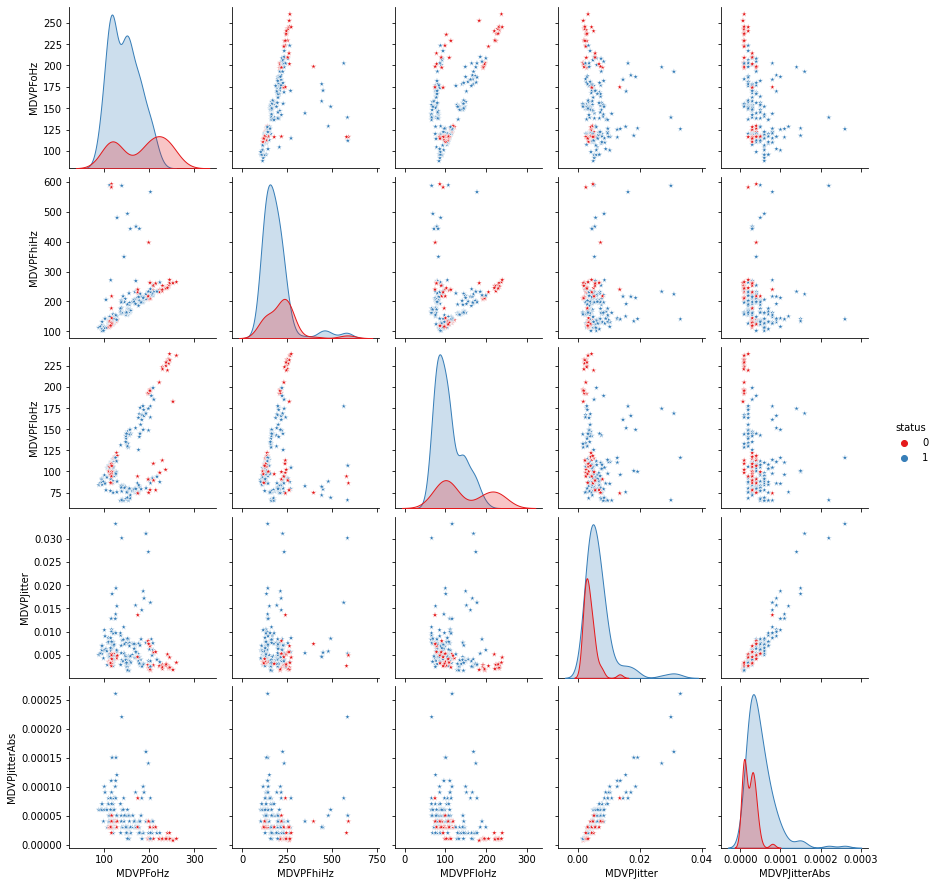

In [9]:
sns.pairplot(df, vars=df.columns[1:6], palette="Set1", hue=label_col, markers='*')

<a id='feature_scaling'></a>
## Feature Scaling

Because the features are on different scales, a plot of the feature distributions side-by-side is not easy to read. 
To visualize the distribution of features relative to each other more easily, one option is to rescale the data. 
Scaling techniques include rescaling between Min and Max, or normalizing around 0 using standard deviation. 

Note that tree-based classifiers can handle unscaled data without problems, but most classifiers relying on a distance metric for convergence perform better with a normalized dataset.

Since the goal is to find a suitable classifier among a variety of options, the data is normalized. 
If the preferred classifier ends up being tree-based, this step can be skipped when creating the final model for production.

In [10]:
scaler = StandardScaler()
scaled_ds = scaler.fit_transform(ds.drop(columns=['name', label_col]))
df2 = pd.DataFrame(scaled_ds, columns=ds.drop(columns=['name', label_col]).columns, index=ds.index)
df2[label_col] = ds[label_col]
df2['name'] = ds['name']

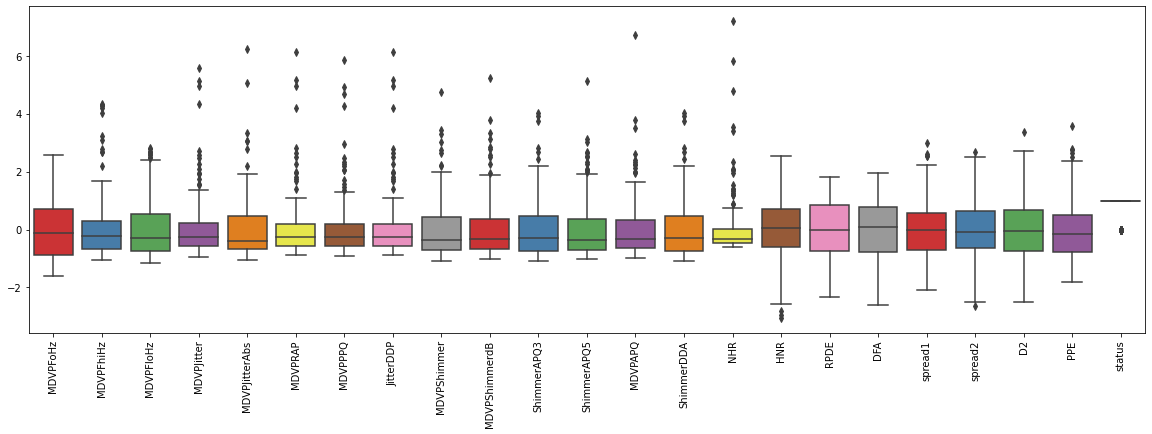

In [11]:
plt.figure(figsize=(20,6))
sns.boxplot(data=df2, palette="Set1")
plt.xticks(rotation=90)
plt.show()

Another way of looking at the distribution of values, is to use a split Violin plot, which shows the distribution curve for each feature, split between the 2 classes.

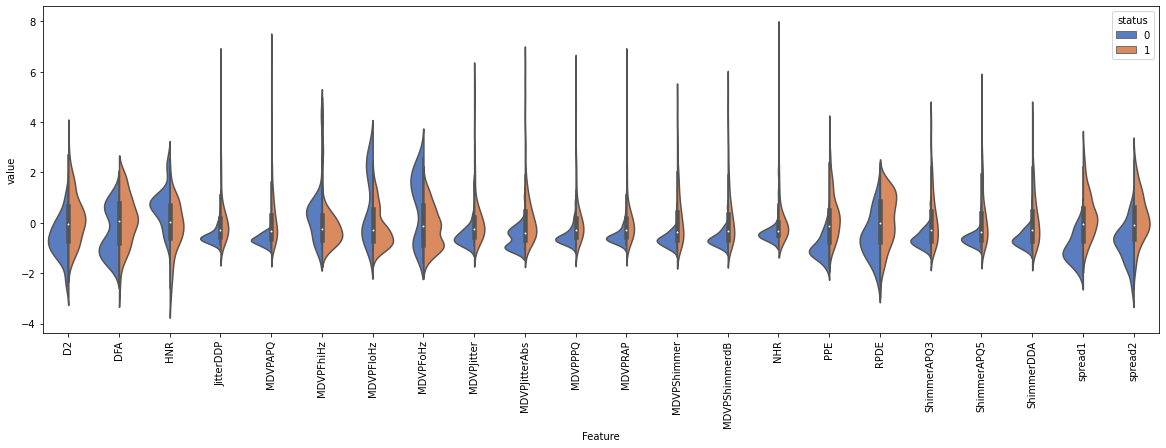

In [12]:
plt.figure(figsize=(20,6))
p = sns.violinplot(x='level_2',
               y=0,
               hue=label_col,
               data=df2.set_index(['name', label_col]).stack().reset_index().sort_values('level_2'), 
               palette="muted", 
               split=True,
               y_label="value"
              )
p.set_xlabel('Feature')
p.set_ylabel('value')
plt.xticks(rotation=90)
plt.show()

<a id="Data_Distribution"></a>
## Distribution of the Target Classes

Visualize the distribution of the target classes. It is slightly imbalanced but that is not critical. When going through the recommendations, the best option is not to re-sample the data.

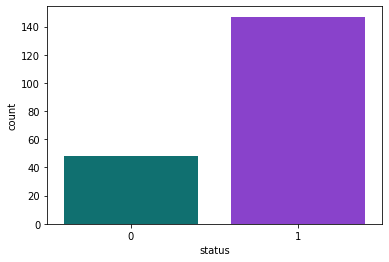

1    147
0     48
Name: status, dtype: int64


In [13]:
sns.countplot(x=label_col, data=df2)
plt.show()
print(df2.status.value_counts())

<a id="split"></a>
## Split Training and Testing datasets, and Separate Target Column

As mentioned previously, there are multiple records per patient in the dataset, so the dataset is split up by selecting a sample among the unique names.

The `name` column won't be needed after this so it can be removed. 

Next the Target column is split up from the features (`X_train` and `X_test`) into its own column (`y_train` and `y_test`)

In [14]:
keys = df2['name'].drop_duplicates().sample(frac=0.2, random_state=0)
train = df2[~df2['name'].isin(keys)]
test = df2[df2['name'].isin(keys)]
print(train.shape)
print(test.shape)

X_train = train.drop(columns=['name', 'status'])
X_test = test.drop(columns=['name', 'status'])
y_train = train['status']
y_test = test['status']

(158, 24)
(37, 24)


<a id='create'></a>
# Model Selection

The next step is to evaluate various classifiers and see which one performs best.

Features are already all floats, so easily ingestable for any machine learning model. Tree-based classifiers can handle categorical data, but most others like Support Vector-based classifiers, regression-based classifiers and Deep Learning models require the data to be all numerical, and would require to encode categorical columns.

<a id='compare_different_models'></a>
## Compare Model performances

In a first method, several classifiers are defined and trained on default parameters, then evaluated and compared.

This is the most flexible method as it allows trying many types of models, even Neural Networks. Later on the AutoML package will be used, which automates a lot of the functionalities and includes hyper-parameters tuning, but only supports standard Machine Learning Models.

In the next section, several models will be tested, including a Deep Neural Network, defined in the next cell.

In [15]:
def build_nn():
    ann = Sequential()
    ann.add(Dense(units=32, activation='relu',input_dim=22))
    ann.add(Dense(units=16, activation='relu'))
    ann.add(Dropout(.2))
    ann.add(Dense(units=8, activation='relu'))
    ann.add(Dense(units=1, activation='sigmoid'))
    ann.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return ann


In [16]:
model_accuracy = pd.DataFrame(columns=['Model','Accuracy'])
models = {
          "LGBMClassifier" : LGBMClassifier(objective='binary', max_depth=3,),
          "KNeighborsClassifier" : KNeighborsClassifier(),
          "DecisionTreeClassifier" : DecisionTreeClassifier(max_depth=3),
          'RandomForestClassifier' : RandomForestClassifier(max_depth=3),
          'GradientBoostingClassifier' : GradientBoostingClassifier(max_depth=3),
          'XGBClassifier' : XGBClassifier(max_depth=3),
          'SupportVectorClassifier' : SVC(kernel='linear'),
          'NeuralNet': KerasClassifier(build_fn=build_nn, batch_size=10, epochs=80)
          }

for model_name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    print(f"{model_name} scores")
    print(f"Accuracy: {acc}")
    print("Classification Report")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))
    
    model_accuracy = model_accuracy.append({'Model': model_name, 'Accuracy': acc, 'Train_acc': train_acc}, ignore_index=True)    
    print('*' * 100,"\n")

model_accuracy.sort_values(ascending=False, by='Accuracy')


LGBMClassifier scores
Accuracy: 1.0
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        31

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37

Confusion Matrix
[[ 6  0]
 [ 0 31]]
**************************************************************************************************** 

KNeighborsClassifier scores
Accuracy: 0.8918918918918919
Classification Report
              precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.91      0.97      0.94        31

    accuracy                           0.89        37
   macro avg       0.83      0.73      0.77        37
weighted avg       0.88      0.89      0.88        37

Confusion Matrix
[[ 3  3]
 [ 1 30]]
**********************************

Model  Accuracy  Train_acc
0              LGBMClassifier  1.000000   1.000000
3      RandomForestClassifier  1.000000   0.936709
5               XGBClassifier  1.000000   1.000000
7                   NeuralNet  1.000000   1.000000
2      DecisionTreeClassifier  0.972973   0.936709
4  GradientBoostingClassifier  0.972973   1.000000
1        KNeighborsClassifier  0.891892   0.936709
6     SupportVectorClassifier  0.891892   0.898734

The model found to be best is the GradientBoostingClassifier which ends up with 93.75% testing accuracy. 

The AutoML module performs more advanced optimizations, with hyper-parameters tuning. The next section covers using AutoML.

<a id="ads_automl"></a>
## Model Selection with ADS AutoML

<a id='custom_adsdataset'></a>
### Custom ADSDataset Class
ADS AutoML is a powerful package able to evaluate models and tuning hyper-parameters to find the best performing model. 

To pick a model, AutoML leverages the ADSDataset classes, and makes use of the class `train_test_split` method. However, 
because the train-test split method used for this dataset is not, we need to superclass the BinaryClassificationDataset class 
and override the train_test_split method with a custom function. The next cell implements the overriding class and 
custom `train_test_split` method. to be used by AutoML.

In [17]:
class MyClassificationDataset(BinaryClassificationDataset):
    def __init__(self, df, sampled_df, target, target_type, shape, positive_class=None, **kwargs):
        super().__init__(df, sampled_df, target, target_type, shape, positive_class=None, **kwargs)
        
    def train_test_split(self, test_size=0.1, random_state=42):
        keys = self.df['name'].drop_duplicates().sample(frac=test_size, random_state=random_state)
        train = self.df[~self.df['name'].isin(keys)]
        test = self.df[self.df['name'].isin(keys)]
        
        X_train = train.drop(columns=['status', 'name'])
        X_test = test.drop(columns=['status', 'name'])
        y_train = train['status']
        y_test = test['status']
        
        train = ADSData.build(
            X=X_train, y=y_train, name="Train Data", dataset_type='BinaryClassificationDataset'
        )
        test = ADSData.build(
            X=X_test, y=y_test, name="Test Data", dataset_type='BinaryClassificationDataset'
        )
        
        return train, test

In [18]:
ds = MyClassificationDataset(df2, df2, target=label_col, target_type=df2[label_col].dtype, shape=df2.shape, positive_class=1)
ds

MyClassificationDataset(target: status) 195 rows, 24 columns

In [19]:
train, test = ds.train_test_split(test_size=0.2, random_state=0)
print(train.X.shape)
print(test.X.shape)

(158, 22)
(37, 22)


<a id='automl_setup'></a>
### AutoML setup

Next the AutoML package is used to define an experiment and try out several models. 
The full list of available models is used (i.e. same as default). The `time_budget` define how much time should be spent looking for the best model.

AutoML also takes multiple providers. `OracleAutoMLProvider is only available within OCI Notebook sessions.

AutoML performs feature selection, hyper-parameter tuning and model selection.

In [20]:
automl = AutoML(train, provider=OracleAutoMLProvider())
model, baseline = automl.train(model_list=[
    'AdaBoostClassifier',
    'DecisionTreeClassifier',
    'ExtraTreesClassifier',
    'KNeighborsClassifier',
    'LGBMClassifier',
    'LinearSVC',
    'LogisticRegression',
    'RandomForestClassifier',
    'SVC',
    'XGBClassifier'
], min_features=['HNR'], score_metric="roc_auc", time_budget=100)

INFO:xengine:All work stopped
INFO:xengine:All work stopped


The `visualize_algorithm_selection_trials` method shows how algorithms are seleted.

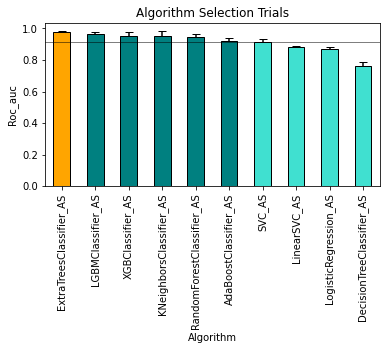

In [21]:
automl.visualize_algorithm_selection_trials()

The `visualize_feature_selection_trials` method visualizes how the number of features is selected for a minimal number of features and best performance metric.


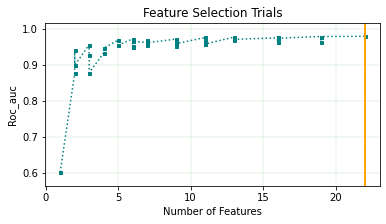

In [22]:
automl.visualize_feature_selection_trials()

The `visualize_tuning_trials` method shows how the evaluation metric improved with iterations.

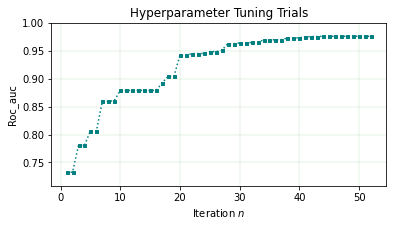

In [23]:
automl.visualize_tuning_trials()

Evaluate the actual accuracy on test data:

In [24]:
accuracy_scorer = get_scorer("accuracy") 
print("Oracle AutoML model accuracy on test data:", model.score(test.X, test.y, score_fn=accuracy_scorer))

Oracle AutoML model accuracy on test data: 1.0


In [25]:
model.predict(test.X[:10])

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0])

In [26]:
test.y[:10]

12    1
13    1
14    1
15    1
16    1
17    1
60    0
61    0
62    0
63    0
Name: status, dtype: int64

In [27]:
print(model)

Framework: sklearn.ensemble._forest
Estimator class: ExtraTreesClassifier
Model Parameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': None, 'max_features': 0.777777778, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 7, 'verbose': 0, 'warm_start': False}



Now the model has been defined and it is known it is a tree-based classifier, it can be retrained on unscaled data, to make it easier to 
infere later on, without the need for a scaling pipeline.

The dataset is redefined from the original Dataframe, and the AutoML model re-run with only the `ExtraTreesClassifier` model.

In [28]:
# redefine the ds with the original, unscaled Dataframe
ds2 = MyClassificationDataset(df, df, target=label_col, target_type=df[label_col].dtype, shape=df.shape, positive_class=1)
train, test = ds2.train_test_split(test_size=0.2, random_state=0)

automl = AutoML(train, provider=OracleAutoMLProvider())
model, baseline = automl.train(model_list=[
    'ExtraTreesClassifier',
], min_features=['HNR'], score_metric="roc_auc", time_budget=100)

INFO:xengine:All work stopped
INFO:xengine:All work stopped
INFO:xengine:All work stopped
INFO:xengine:All work stopped


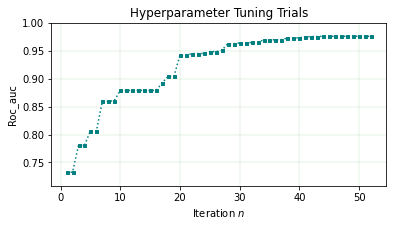

In [29]:
automl.visualize_tuning_trials()

In [30]:
print("Oracle AutoML model accuracy on test data:", model.score(test.X, test.y, score_fn=accuracy_scorer))

Oracle AutoML model accuracy on test data: 1.0


<a id="explain"></a>
# Explaining the Model

In this section, the ADS Explainer package is used to look at the model behavior and sensitivity to variation in given features.

<a id="whatlearned"></a>
## Show what the model has learned

It is great to have an expert with knowledge of what a model should do. However, this is often not available. Models sometimes learn different things than what an expert would speculate. Generally, models learn important relationships between the features. For many machine learning models, it is difficult to understand what the model has learned. 

The `ADSExplainer` provides a powerful set of tools that provide the data scientist insight into what the model is doing. It does this by building other models and performing simulations on the model's predictions. From this, the `ADSExplainer` learns what has been learned. 

When an explanation does not make sense, it does not mean the explanation is wrong. It is possible that the model has learned new relationships in the data. This shows how `MLX` can be used to understand and debug the modeling process.

In [31]:
explainer = ADSExplainer(test, model)

<a id='global'></a>
## Global Explanations

Generating global explanations for the model:

Using the `ADSExplainer` object, the `global_explanation` method creates a generator for global model explanations. Oracle Labs global `MLX` is selected as the provider using the `MLXGlobalExplainer` object. Global explanation supports both feature importance explanations and feature dependence explanations, such as Partial Dependence Plots (PDP) and Individual Conditional Expectations (ICE). 

First, look at feature importance, which provides a list of features sorted by their ability to influence the predictions.

In [32]:
global_explainer = explainer.global_explanation(provider=MLXGlobalExplainer())
importances = global_explainer.compute_feature_importance()
importances.show_in_notebook(n_features=10)

MLXProgBar:   0%|          | 0/20 [00:00<?, ?it/s]

MLXProgBar:   0%|          | 0/3 [00:00<?, ?it/s]

MDVPFoHz, PPE and spread1 are the most important features for this model.


The `detailed` mode provides scatter plot which shows the distribution of the importance measure and provides a sense of the variation in the data. The top 10 features are plotted.

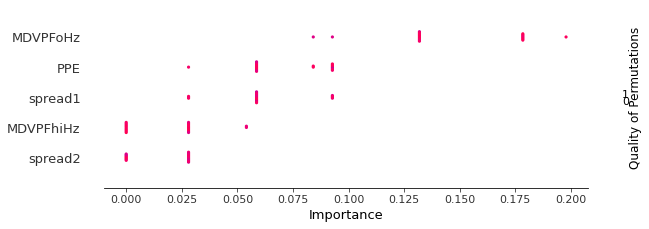

In [33]:
importances.show_in_notebook(n_features=5, mode='detailed')

<a id="feat_dep_exp"></a>
### Feature Dependence Explanations (PDP & ICE)

Next, visualize how different values for the important features interact with the target variable. This is done through Partial Dependence Plots (PDP) and Individual Conditional Expectations (ICE) explanations. 

The following cell shows how to learn more about the PDP and ICE techniques used in the `MLXGlobalExplainer`. This provides a description of the algorithm and how to interpret the output. 

In [34]:
global_explainer.partial_dependence_summary()

Look at the top most important features to see the distribution of its values and the outcome on the prediction P(1)

In [35]:
explanation = explainer.global_explanation().compute_partial_dependence("PPE")
explanation.show_in_notebook(mode="pdp", labels=[1])

MLXProgBar:   0%|          | 0/30 [00:00<?, ?it/s]

In [36]:
explanation.show_in_notebook(mode="ice", centered=False, 
                              show_distribution=True, 
                              show_correlation_warning=True, 
                              show_median=True,
                              labels=[1])

Next, look at the dependence of variables `MDVPFoHz` and `PPE` to see in what combination of variables the model 

In [37]:
otjl_explanation = explainer.global_explanation().compute_partial_dependence(['MDVPFoHz', 'PPE'])
otjl_explanation.show_in_notebook(show_distribution=True, show_correlation_warning=False, line_gap=1)

MLXProgBar:   0%|          | 0/900 [00:00<?, ?it/s]

<a id="whatif"></a>
## What-if Scenarios 

Using the `ADSExplainer` object, "WhatIf" explanation object can be created to generate model explanations. Oracle Labs WhatIf `MLX` is selected as the provider using the `MLXWhatIfExplainer` object. WhatIf explanation supports both explore sample and explore predictions.

In [38]:
whatif_explainer = explainer.whatif_explanation(provider=MLXWhatIfExplainer())

### Predictions Explorer

The predictions Explorer tool allows you to explore model predictions across either the marginal distribution (1-feature) or the joint distribution (2-feature) of the features in your train/validation/test dataset. The method `explore_predictions()` has several optional parameters including: 

* `feature`: the name of the feature to visualize 
* `label`: either the target label index or name to visualize 
* `plot_type`: `scatter`, `bar`, `box`.
* `discretization`: method to discretize continuous features (Options are no discretization, quartile, decile, or percentile)

Try the top features and observe that the Positive predictions are well discriminated with these features.

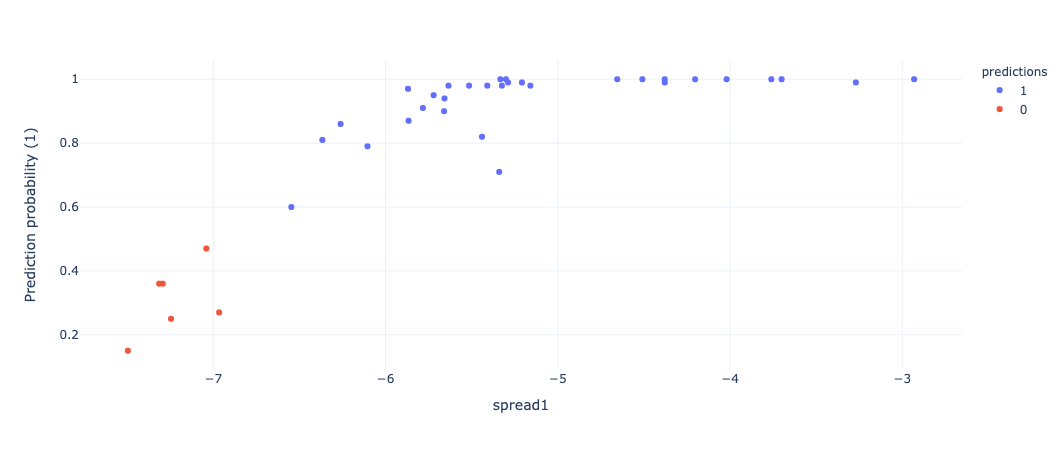

In [40]:
# whatif_explainer.explore_predictions('MDVPFoHz')
# whatif_explainer.explore_predictions('PPE')
whatif_explainer.explore_predictions('spread1')

<a id='localexplanations'></a>
## Local Explanations

Global explanations inform the data scientist about the general trends in a model. They do not describe what is happening with a specific prediction. That is the role of local explanations. They are model-agnostic and provide insights into why a model made a specific prediction.  

The explainer provides useful insight on the direction each feature has influenced the final prediction.

In [41]:
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
local_explainer = explainer.local_explanation(provider=MLXLocalExplainer())

sample = 4
(X, y) = test.X.iloc[[sample]], test.y.iloc[[sample]]

local_explainer.explain(X, y).show_in_notebook(labels=1)

MLXProgBar:   0%|          | 0/1 [00:00<?, ?it/s]

<a id='serialize'></a>
# Model Deployment

The model is trained and working well. The next step is to make it available to the world to infer on unknown samples.

ADS model.framework makes it easy to deploy a model into production. It supports several types of models, including `AutoML`, `LightGBM`, `PyTorch`, `Sklearn`, `TensorFlow`, and `XGBoost` models. The constructor takes a model and converts it into an ADS object meant for model serialization and deployment. 

Deploying the model into production requires a few steps: `prepare` the model artifact, creating a bundle of files inference code, and metadata about the input and output schemas, the model provenance and environment where it was trained. `verify` the artifact, by testing the generated inference code locally. `save` the model to the model catalog, and then `deploy`. Once deployed, using the `predict` method calls the deployment endpoint to infere from the deployed model.

ADS provides the `.summary_status()` method that outputs a dataframe that defines the steps, status, and detailed information about each step. 

<a id='serialize_sklearnmodel'></a>
## Create a Serialized Model

The AutoML model created previously model is the model to deploy.

The `AutoMLModel()` constructor takes an AutoML model along with the path where to store the model artifacts. An `AutoMLModel` object is returned, and it is used to manage the deployment.

The next cell creates a temporary model artifact directory, sets the authentication to use resource principal (required to check on deployment status), and creates the `AutoMLModel` object.

In [42]:
artifact_dir = tempfile.mkdtemp()
ads.set_auth(auth='resource_principal')
automl_model = AutoMLModel(estimator=model, artifact_dir=artifact_dir)

The `.summary_status()` method of the `AutoMLModel` class is a handy method to keep track of the progress that you are making in deploying the model. It creates a dataframe that lists the deployment steps, thier status, and details about them. The next cell returns the summary status dataframe. It shows that the initiate step has been completed.

In [43]:
automl_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Available     Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Not Available Local tested .predict from score.py                               
save()    Not Available Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  Not Available Deployed the model                                                
predict() Not Available Called deployment predict endpoint

<a id='serialize_prepare'></a>
## Prepare the Model Artifacts

The prepare step is performed by the `.prepare()` method of the `AutoMLModel` class. It creates a number of customized files that are used to run the model once it is deployed. These include:

* `input_schema.json`: A JSON file that defines the nature of the features of the `X_sample` data. It includes metadata such as the data type, name, constraints, summary statistics, feature type, and more.
* `model.joblib`: This is the default filename of the serialized model. It can be changed with the `model_file_name` attribute. By default, the model is stored in a joblib file. The parameter `as_onnx` can be used to save it in the ONNX format.
* `output_schema.json`: A JSON file that defines the nature of the dependent variable in the `y_sample` data. It includes metadata such as the data type, name, constraints, summary statistics, feature type, and more.
* `runtime.yaml`: This file contains information that is needed to set up the runtime environment on the deployment server. It has information about which conda environment was used to train the model, and what environment should be used to deploy the model. The file also specifies what version of Python should be used.
* `score.py`: This script contains the `load_model()` and `predict()` functions. The `load_model()` function understands the format the model file was saved in and loads it into memory. The `.predict()` method is used to make inferences in a deployed model. There are also hooks that allow you to perform operations before and after inference. You can modify this script to fit your specific needs.

To create the model artifacts, you use the `.prepare()` method. There are a number of parameters that allow you to store model provenance information. In the next cell, the `conda_env` variable defines the slug of the conda environment that was used to train the model, and also the conda environment that should be used for deployment. Note that you can only pass in slugs to `inference_conda_env` or `training_conda_env` if it's a service environment. Otherwise, you must pass in the full path of the conda envvironment along with the python version through `inference_python_version` and `training_python_version`.

In [44]:
conda_env = 'generalml_p37_cpu_v1'

automl_model.prepare(
    inference_conda_env=conda_env,
    training_conda_env=conda_env,
    use_case_type=UseCaseType.BINARY_CLASSIFICATION,
    X_sample=X_test,
    y_sample=y_test,
)

The next cell uses the `.summary_status()` method to show you that the prepare step finished, and what tasks were completed.

In [45]:
automl_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Available     Local tested .predict from score.py                               
save()    Available     Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  Not Available Deployed the model                                                
predict() Not Available Called deployment predict endpoint

The `.prepare()` method has created the following files. These files are fully functional. However, you can modify them to fit your specific needs.

In [46]:
os.listdir(artifact_dir)

['input_schema.json',
 'score.py',
 'model.pkl',
 'runtime.yaml',
 'output_schema.json']

Once the artifacts have been created, there are a number of attributes in the `AutoMLModel` object that provides metadata about the model. The `.runtime` attribute details the model deployment settings and model provenance data.

In [47]:
automl_model.runtime_info

model_artifact_version: '3.0'
model_deployment:
  inference_conda_env:
    inference_env_path: oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/General_Machine_Learning_for_CPUs_on_Python_3.7/1.0/generalml_p37_cpu_v1
    inference_env_slug: generalml_p37_cpu_v1
    inference_env_type: data_science
    inference_python_version: '3.7'
model_provenance:
  project_ocid: ''
  tenancy_ocid: ''
  training_code:
    artifact_directory: /tmp/tmpxr6jncu9
  training_compartment_ocid: ''
  training_conda_env:
    training_env_path: oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/General_Machine_Learning_for_CPUs_on_Python_3.7/1.0/generalml_p37_cpu_v1
    training_env_slug: generalml_p37_cpu_v1
    training_env_type: data_science
    training_python_version: '3.7'
  training_region: ''
  training_resource_ocid: ''
  user_ocid: ''
  vm_image_internal_id: ''

The `.schema_input` attribute provides metadata on the features that were used to train the model. You can use this information to determine what data must be provided to make model inferences. Each feature in the model has a section that defines the dtype, feature type, name, and if it is required. The metadata also includes the summary statistics associated with the feature type.

In [48]:
automl_model.schema_input

schema:
- description: MDVPPPQ
  domain:
    constraints: []
    stats:
      count: 37.0
      lower quartile: -0.515
      mean: 0.245
      median: -0.119
      sample maximum: 4.664
      sample minimum: -0.842
      skew: 2.358
      standard deviation: 1.254
      upper quartile: 0.394
    values: Continuous
  dtype: float64
  feature_type: Continuous
  name: MDVPPPQ
  order: 6
  required: true
- description: ShimmerAPQ3
  domain:
    constraints: []
    stats:
      count: 37.0
      lower quartile: -0.546
      mean: 0.672
      median: 0.561
      sample maximum: 3.935
      sample minimum: -0.899
      skew: 0.776
      standard deviation: 1.236
      upper quartile: 1.485
    values: Continuous
  dtype: float64
  feature_type: Continuous
  name: ShimmerAPQ3
  order: 10
  required: true
- description: MDVPJitter
  domain:
    constraints: []
    stats:
      count: 37.0
      lower quartile: -0.523
      mean: 0.324
      median: -0.211
      sample maximum: 5.571
      sampl

The `.metadata_custom` attribute provides custom metadata that contains information on the category of the metadata, description, key, and value.

In [49]:
automl_model.metadata_custom

data:
- category: Other
  description: ''
  key: ClientLibrary
  value: ADS
- category: Training Environment
  description: The conda environment type, can be published or datascience.
  key: EnvironmentType
  value: data_science
- category: Training Profile
  description: The model serialization format.
  key: ModelSerializationFormat
  value: pkl
- category: Training Environment
  description: The conda environment where the model was trained.
  key: CondaEnvironment
  value: oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/General_Machine_Learning_for_CPUs_on_Python_3.7/1.0/generalml_p37_cpu_v1
- category: Training Environment
  description: The list of files located in artifacts folder.
  key: ModelArtifacts
  value: score.py, model.pkl, runtime.yaml
- category: Training Environment
  description: The slug name of the training conda environment.
  key: SlugName
  value: generalml_p37_cpu_v1
- category: Training Environment
  description: The URI of the training conda environ

The `.metadata_provenance` contains information about the code and training data that was used to create the model. This information is most useful when a Git repository is being used to manage the code for training the model. This is considered a best practice because it allows you to do things like reproduce a model, perform forensic on the model, and so on.

In [50]:
automl_model.metadata_provenance

artifact_dir: null
git_branch: null
git_commit: null
repo: null
repository_url: null
training_id: null
training_script_path: null

The `.metadata_taxonomy` is a key-value store that has information about the classification or taxonomy of the model. This can include information such as the model framework, use case type, hyperparameters, and more.

In [51]:
automl_model.metadata_taxonomy

data:
- key: Algorithm
  value: ensemble
- key: Framework
  value: oracle_automl
- key: UseCaseType
  value: binary_classification
- key: FrameworkVersion
  value: '1.0'
- key: Hyperparameters
  value: null
- key: ArtifactTestResults
  value: null

<a id='serialize_verify'></a>
## Verify: Test the Model Locally

If you modify the `score.py` file that is part of the model artifacts, then you should verify it. The verify step allows you to test those changes without having to deploy the model. This allows you to debug your code without having to save the model to the model catalog and then deploy it. The `.verify()` method takes a set of test parameters and performs the prediction by calling the `predict` function in `score.py`. It also runs the `load_model` function.

The next cell simulates a call to a deployed model without having to actually deploy the model. It passes in test values and returns the predictions.

In [52]:
df[25:35]

name  MDVPFoHz  MDVPFhiHz  MDVPFloHz  MDVPJitter  MDVPJitterAbs  \
25  phon_R01_S06   104.400    206.002     77.968     0.00633       0.000060   
26  phon_R01_S06   171.041    208.313     75.501     0.00455       0.000030   
27  phon_R01_S06   146.845    208.701     81.737     0.00496       0.000030   
28  phon_R01_S06   155.358    227.383     80.055     0.00310       0.000020   
29  phon_R01_S06   162.568    198.346     77.630     0.00502       0.000030   
30  phon_R01_S07   197.076    206.896    192.055     0.00289       0.000010   
31  phon_R01_S07   199.228    209.512    192.091     0.00241       0.000010   
32  phon_R01_S07   198.383    215.203    193.104     0.00212       0.000010   
33  phon_R01_S07   202.266    211.604    197.079     0.00180       0.000009   
34  phon_R01_S07   203.184    211.526    196.160     0.00178       0.000009   

    MDVPRAP  MDVPPPQ  JitterDDP  MDVPShimmer  ...  ShimmerDDA      NHR  \
25  0.00316  0.00375    0.00948      0.03767  ...     0.05197  0.02887   
26  0.00250  0.00234    0.00750      0.01966  ...     0.02666  0.01095   
27  0.00250  0.00275    0.00749      0.01919  ...     0.02650  0.01328   
28  0.00159  0.00176    0.00476      0.01718  ...     0.02307  0.00677   
29  0.00280  0.00253    0.00841      0.01791  ...     0.02380  0.01170   
30  0.00166  0.00168    0.00498      0.01098  ...     0.01689  0.00339   
31  0.00134  0.00138    0.00402      0.01015  ...     0.01513  0.00167   
32  0.00113  0.00135    0.00339      0.01263  ...     0.01919  0.00119   
33  0.00093  0.00107    0.00278      0.00954  ...     0.01407  0.00072   
34  0.00094  0.00106    0.00283      0.00958  ...     0.01403  0.00065   

       HNR  status      RPDE       DFA   spread1   spread2        D2       PPE  
25  22.066       1  0.522746  0.737948 -5.571843  0.236853  2.846369  0.219514  
26  25.908       1  0.418622  0.720916 -6.183590  0.226278  2.589702  0.147403  
27  25.119       1  0.358773  0.726652 -6.271690  0.196102  2.314209  0.162999  
28  25.970       1  0.470478  0.676258 -7.120925  0.279789  2.241742  0.108514  
29  25.678       1  0.427785  0.723797 -6.635729  0.209866  1.957961  0.135242  
30  26.775       0  0.422229  0.741367 -7.348300  0.177551  1.743867  0.085569  
31  30.940       0  0.432439  0.742055 -7.682587  0.173319  2.103106  0.068501  
32  30.775       0  0.465946  0.738703 -7.067931  0.175181  1.512275  0.096320  
33  32.684       0  0.368535  0.742133 -7.695734  0.178540  1.544609  0.056141  
34  33.047       0  0.340068  0.741899 -7.964984  0.163519  1.423287  0.044539  

[10 rows x 24 columns]

In [53]:
feature_columns = [f['name'] for f in sorted(automl_model.schema_input.to_dict().get('schema'), key=lambda x: x['order'])]
automl_model.verify(df[25:35][feature_columns])

INFO:xengine:All work stopped
INFO:xengine:All work stopped
Start loading model.pkl from model directory /tmp/tmpxr6jncu9 ...
Model is successfully loaded.


{'prediction': [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]}

The `.summary_status()` method is updated to show that the verify step has been completed.

In [54]:
automl_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Done          Local tested .predict from score.py                               
save()    Available     Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  Not Available Deployed the model                                                
predict() Not Available Called deployment predict endpoint

<a id='serialize_save'></a>
## Save the Model in the Model Catalog

Once you are satisfied with the performance of the model and have verified that the `score.py` file is working, you can save the model to the model catalog. You do this with the `.save()` method on a `AutoMLModel` object. This bundles up the model artifact that you have created, and push it to the model catalog. It returns the model OCID. It's important to keep track of this id, as it is used to delete the model later.

In [176]:
model_id = automl_model.save(display_name='parkinson_demo')

INFO:xengine:All work stopped
INFO:xengine:All work stopped
Start loading model.pkl from model directory /tmp/tmporx7m9r7 ...
Model is successfully loaded.
['input_schema.json', 'score.py', 'model.pkl', 'runtime.yaml', 'output_schema.json']


loop1:   0%|          | 0/5 [00:00<?, ?it/s]

artifact:/tmp/saved_model_38ab4f28-f1ed-4686-bfa2-fdd9aefa5704.zip


In [177]:
model_id

'ocid1.datasciencemodel.oc1.phx.amaaaaaanif7xwiak6p47aynhoyldujv27bbs3xjkhtwsudcx7d6prnilyva'

<a id='serialize_deploy'></a>
## Deploy

With the model in the model catalog, you can use the `.deploy()` method to deploy the model. This method allows you to specify the attributes of the deployment such as the display name, description, instance type and count, the maximum bandwidth, and logging groups. The next cell deploys the model with the default settings, except for the custom display name. The `.deploy()` method returns a `ModelDeployment` object.

In [178]:
deployment = automl_model.deploy(display_name='parkinson_demo_model_deployment')

loop1:   0%|          | 0/6 [00:00<?, ?it/s]

After deployment, the `.summary_status()` method shows that the model is ACTIVE and the `predict()` method is available.

In [255]:
automl_model.summary_status()

Actions Needed
Step      Status    Details                                                           
initiate  Done      Initiated the model                                               
prepare() Done      Generated runtime.yaml                                            
                    Generated score.py                                                
                    Serialized model                                                  
                    Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Done      Local tested .predict from score.py                               
save()    Done      Conducted Introspect Test                                         
                    Uploaded artifact to model catalog                                
deploy()  ACTIVE    Deployed the model                                                
predict() Available Called deployment predict endpoint

<a id='serialize_predict'></a>
## Predict

Earlier you used the `model.predict()` method where `model` was an `ADSModel` object. This did inference using the local model. Now that the `XGBoostModel` model has been deploy, the `.predict()` method is available to do inference on the deployed model. It effectively calls the deployed model endpoint.


In [280]:
df

name  MDVPFoHz  MDVPFhiHz  MDVPFloHz  MDVPJitter  MDVPJitterAbs  \
0    phon_R01_S01   119.992    157.302     74.997     0.00784        0.00007   
1    phon_R01_S01   122.400    148.650    113.819     0.00968        0.00008   
2    phon_R01_S01   116.682    131.111    111.555     0.01050        0.00009   
3    phon_R01_S01   116.676    137.871    111.366     0.00997        0.00009   
4    phon_R01_S01   116.014    141.781    110.655     0.01284        0.00011   
..            ...       ...        ...        ...         ...            ...   
190  phon_R01_S50   174.188    230.978     94.261     0.00459        0.00003   
191  phon_R01_S50   209.516    253.017     89.488     0.00564        0.00003   
192  phon_R01_S50   174.688    240.005     74.287     0.01360        0.00008   
193  phon_R01_S50   198.764    396.961     74.904     0.00740        0.00004   
194  phon_R01_S50   214.289    260.277     77.973     0.00567        0.00003   

     MDVPRAP  MDVPPPQ  JitterDDP  MDVPShimmer  ...  ShimmerDDA      NHR  \
0    0.00370  0.00554    0.01109      0.04374  ...     0.06545  0.02211   
1    0.00465  0.00696    0.01394      0.06134  ...     0.09403  0.01929   
2    0.00544  0.00781    0.01633      0.05233  ...     0.08270  0.01309   
3    0.00502  0.00698    0.01505      0.05492  ...     0.08771  0.01353   
4    0.00655  0.00908    0.01966      0.06425  ...     0.10470  0.01767   
..       ...      ...        ...          ...  ...         ...      ...   
190  0.00263  0.00259    0.00790      0.04087  ...     0.07008  0.02764   
191  0.00331  0.00292    0.00994      0.02751  ...     0.04812  0.01810   
192  0.00624  0.00564    0.01873      0.02308  ...     0.03804  0.10715   
193  0.00370  0.00390    0.01109      0.02296  ...     0.03794  0.07223   
194  0.00295  0.00317    0.00885      0.01884  ...     0.03078  0.04398   

        HNR  status      RPDE       DFA   spread1   spread2        D2  \
0    21.033       1  0.414783  0.815285 -4.813031  0.266482  2.301442   
1    19.085       1  0.458359  0.819521 -4.075192  0.335590  2.486855   
2    20.651       1  0.429895  0.825288 -4.443179  0.311173  2.342259   
3    20.644       1  0.434969  0.819235 -4.117501  0.334147  2.405554   
4    19.649       1  0.417356  0.823484 -3.747787  0.234513  2.332180   
..      ...     ...       ...       ...       ...       ...       ...   
190  19.517       0  0.448439  0.657899 -6.538586  0.121952  2.657476   
191  19.147       0  0.431674  0.683244 -6.195325  0.129303  2.784312   
192  17.883       0  0.407567  0.655683 -6.787197  0.158453  2.679772   
193  19.020       0  0.451221  0.643956 -6.744577  0.207454  2.138608   
194  21.209       0  0.462803  0.664357 -5.724056  0.190667  2.555477   

          PPE  
0    0.284654  
1    0.368674  
2    0.332634  
3    0.368975  
4    0.410335  
..        ...  
190  0.133050  
191  0.168895  
192  0.131728  
193  0.123306  
194  0.148569  

[195 rows x 24 columns]

In [281]:
automl_model.predict(df[25:35][feature_columns])

ERROR:ads.common:ADS Exception
Traceback (most recent call last):
  File "/home/datascience/conda/generalml_p37_cpu_v1/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-281-8fe77282aace>", line 1, in <module>
    automl_model.predict(df[feature_columns])
  File "/home/datascience/conda/generalml_p37_cpu_v1/lib/python3.7/site-packages/ads/model/generic_model.py", line 1194, in predict
    raise ValueError("Use `deploy()` method to start model deployment.")
ValueError: Use `deploy()` method to start model deployment.


ValueError: Use `deploy()` method to start model deployment.

<a id='req_resp'></a>
## Invoking the REST Endpoint

To invoke the RESRT endpoint, JSON data needs to be passed to the HTTP call. The test data is created from raw data by selecting the appropriate columns and exporting to JSON with pandas `to_json` method.

Then a HTTP POST request is sent to the endpoint, and results are received as JSON.

In [185]:
input_data = df[25:35][feature_columns].to_json(orient='records')
endpoint = f"{deployment.url}/predict"
auth = oci.auth.signers.get_resource_principals_signer()

requests.post(endpoint, json={'data': input_data, 'data_type':"pandas.core.frame.DataFrame"}, auth=auth).json()

{'prediction': [1, 1]}

<a id='clean_up'></a>
# Clean Up

This notebook created a model deployment and a model. This section cleans up those resources. 

The model deployment must be deleted before the model can be deleted. You use the `.delete_deployment()` method on the `SklearnModel` object to do this.

In [55]:
delete = automl_model.delete_deployment(wait_for_completion=True)

After the model deployment has been deleted, the `.summary_status()` method shows that the model has been deleted and that the `predict()` method is not available.

In [56]:
automl_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Done          Local tested .predict from score.py                               
save()    Done          Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  DELETED       Deployed the model                                                
predict() Not Available Called deployment predict endpoint

Use the `.delete_model()` method in a `ModelCatalog` object to delete the model.

In [57]:
ModelCatalog(compartment_id=os.environ['NB_SESSION_COMPARTMENT_OCID']).delete_model(model_id)

True

The next cell removes the model artifacts that were stored on your local drive.

In [58]:
rmtree(artifact_dir)

<a id='ref'></a>
# References
- [ADS Library Documentation](https://docs.cloud.oracle.com/en-us/iaas/tools/ads-sdk/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)
- [Understanding Conda Environments](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/use-notebook-sessions.htm#conda_understand_environments)
- [Use Resource Manager to Configure Your Tenancy for Data Science](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/orm-configure-tenancy.htm)
- [`runtime.yaml`](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/model_runtime_yaml.htm#model_runtime_yaml)
- [`score.py`](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/model_score_py.htm#model_score_py)
- [Model artifact](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/models_saving_catalog.htm#create-models)
- [ONNX API Summary](http://onnx.ai/sklearn-onnx/api_summary.html)